# simulated pump probe for testing ridge, constrained, or more advanced regression

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import binned_statistic_dd
from scipy import optimize
from scipy.optimize import least_squares
from scipy.optimize import leastsq
from scipy.optimize import minimize
import scipy.linalg
import itertools

## making simulated data

In [51]:
def y(t,a,w,phi,tau):
    return np.heaviside(t,0)*(-5*np.exp(-t/tau)+a*np.exp(-t/tau)*np.sin(w*t+phi))
    


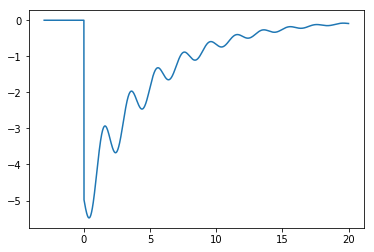

In [52]:
t = np.arange(-3,20,0.01)
plt.plot(t,y(t,1,np.pi,3.1,5))

In [53]:
t_sim     =  np.random.rand(40*len(t))*23-3
e_sim     =  np.random.normal(916,9,len(t_sim))
e_noisy   =  e_sim + np.random.normal(0,9,len(t_sim))
y_sim     =  (1+1e-1*y(t_sim,1,np.pi,3.1,5) +1e-1*np.random.normal(0,1,len(t_sim)))
IFEE_sim  =   np.random.normal(2,0.4,len(t_sim))
I0_sim    =  IFEE_sim*np.exp(-(913-e_noisy)**2/2**2)+1e-1*np.random.normal(0.0,0.2,len(t_sim))**2
I_sim     =  I0_sim*y_sim*(1+(e_sim-885)*1) +1e-2*np.random.normal(0,0.8,len(t_sim))**2

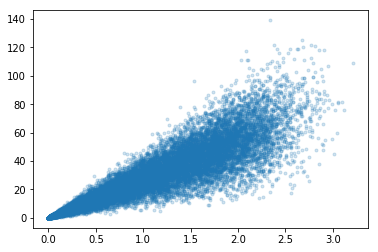

In [54]:
plt.plot(I0_sim,I_sim,'.',alpha=0.2)

(0, 9.325955924983887)

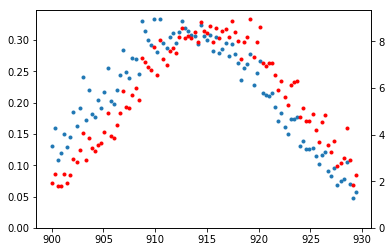

In [55]:
my_bins = np.arange(900,930,0.3)

my_binned_stat = binned_statistic_dd(e_sim,I0_sim,bins=[my_bins],statistic=np.average)
plt.plot(my_binned_stat.bin_edges[0][:-1],my_binned_stat.statistic,'.',alpha=1)
plt.ylim(0,)
plt.twinx()
my_binned_stat = binned_statistic_dd(e_sim,I_sim,bins=[my_bins],statistic=np.average)
plt.plot(my_binned_stat.bin_edges[0][:-1],my_binned_stat.statistic,'.',alpha=1,color='r')
plt.ylim(0,)

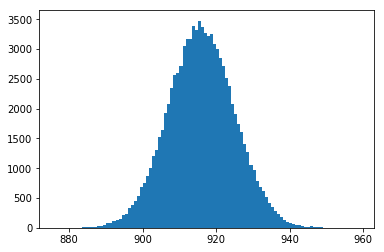

In [56]:
dummy_hist = plt.hist(e_sim,bins=100)

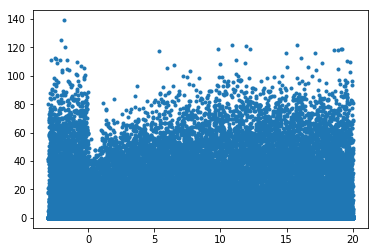

In [57]:
plt.plot(t_sim,I_sim,'.')
plt.show()

### making big matrix for linearized system


In [58]:
#make giant matrix
t_bins = np.arange(-3,20,0.05)

my_pump_probe = []

big_X       = np.zeros([I_sim.shape[0],t_bins.shape[0]*4])
reordered_Y = np.array([])



my_col = 0
my_row = 0

my_ycol = 0
my_yrow = 0
digitized_indices =  np.digitize(t_sim,t_bins)


for i in np.arange(len(t_bins)):
    my_mask  = (digitized_indices==i+1)
    
    X = (np.array([np.ones(np.sum(my_mask)),
                   I0_sim[my_mask],
                   (e_sim[my_mask]-np.mean(e_sim[my_mask])),
                   (I0_sim[my_mask]-np.mean(I0_sim[my_mask]))*(e_sim[my_mask]-np.mean(e_sim[my_mask])) ])).transpose()

    
    big_X[my_row:my_row+X.shape[0],my_col:my_col + X.shape[1]] = X

    reordered_Y = np.append(reordered_Y,I_sim[my_mask])
    
    my_col = my_col + X.shape[1]
    my_row = my_row + X.shape[0]
    


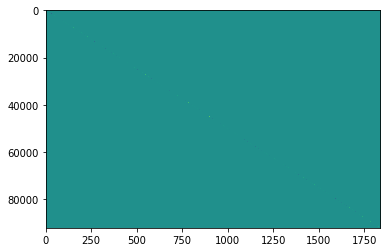

In [59]:
plt.imshow(big_X,aspect='auto')
plt.show()

In [60]:
big_X.shape

(92000, 1840)

In [61]:
reordered_Y.shape

(92000,)

In [13]:
pseudo_inv = np.linalg.pinv(big_X)

In [97]:
ridge_matrix = np.zeros([big_X.shape[1],big_X.shape[1]])
#ridge_matrix           = np.zeros([1840])
#ridge_matrix[:3]       = np.array([1,-2,1])
#ridge_matrix           = scipy.linalg.toeplitz(ridge_matrix)[1:,:-1]
regularization_0 = 0
regularization_1 = 0
regularization_2 = 1e9
regularization_3 = 0
for i,j in itertools.combinations_with_replacement(range(0,ridge_matrix.shape[0],4),2):
    if(i==j):
        ridge_matrix[i,j]=-2*regularization_0
    elif(i==j-4 ):
        ridge_matrix[i,j]=1*regularization_0

for i,j in itertools.combinations_with_replacement(range(2,ridge_matrix.shape[0],4),2):
    if(i==j):
        ridge_matrix[i,j]=-2*regularization_2
    elif(i==j-4 ):
        ridge_matrix[i,j]=1*regularization_2

for i,j in itertools.combinations_with_replacement(range(1,ridge_matrix.shape[0],4),2):
    if(i==j):
        ridge_matrix[i,j]=-2*regularization_1
    elif(i==j-4 ):
        ridge_matrix[i,j]=1*regularization_1
        
for i,j in itertools.combinations_with_replacement(range(3,ridge_matrix.shape[0],4),2):
    if(i==j):
        ridge_matrix[i,j]=-2*regularization_3
    elif(i==j-4 ):
        ridge_matrix[i,j]=1*regularization_3

In [98]:
#my_coefs=np.dot(pseudo_inv,reordered_Y)
my_coefs = np.dot(np.dot(np.linalg.inv(np.dot(big_X.transpose(),
                            big_X)+np.dot(ridge_matrix.transpose(),
                                          ridge_matrix)),big_X.transpose()),reordered_Y)

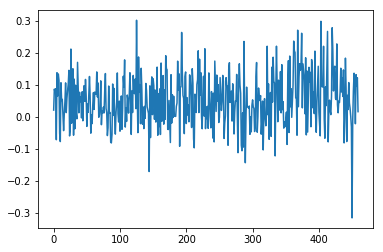

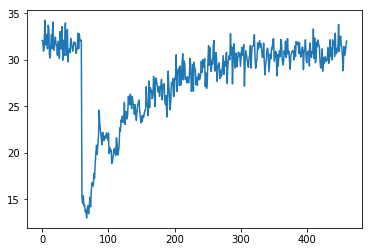

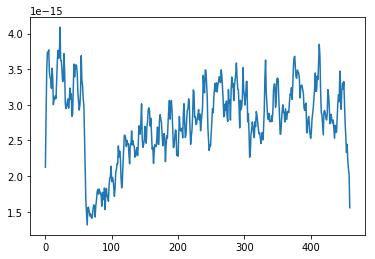

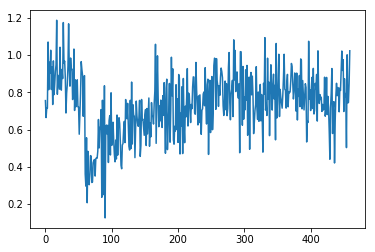

In [99]:
for i in range(4):
    plt.plot(my_coefs[i::4],'-')
    plt.show()